## Blockchain Research: Oracle Attack
### Catherine Gu wcgu@stanford.edu, Stanford University

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
from tqdm import tqdm
from functools import reduce
import scipy.stats as sts

ModuleNotFoundError: No module named 'chart_studio'

In [2]:
cwd = os.getcwd()

In [3]:
def error_check(j):
    timeStamp = [int(each['timeStamp'],16) for each in j]
    block = [int(each['blockNumber'],16) for each in j]
    count = 0
    count_error = 0
    for each in j:
        if len(each['topics']) == 4:
            count += 1
        else:
            count_error += 1
    print(count, count_error)

    
def check_boolean_is_false(j):
    count = 0
    for each in j:
        timeStamp = int(each['timeStamp'],16)
        if len(each['topics']) == 4:
            zzz = int(each['topics'][3][-8:],16)
            if timeStamp > zzz:
                count += 1
    print(count)

In [4]:
files = []
cwd = os.getcwd()
for i in range(14):
    filename = str(cwd + '/' + str(i+1) + '/out')
    j = json.load(open(filename))['result']
#     print("How many booleans return False, i.e. now > zzz"), check_boolean_is_false(j)
#     print("No of price reported, number of price not reported"), print(len(j)), error_check(j)

In [5]:
def get_number(feeder):
    list_0_3 = ['14']
    list_0_4 = ['3', '4', '5', '10', '11', '13']
    list_0_5 = ['1', '2', '7',]
    list_0_6 = ['9', '12']
    list_0_7 = ['8']
    list_0_8 = ['6']
    if feeder in list_0_3:
        return 4;
    if feeder in list_0_4:
        return 5;
    if feeder in list_0_5:
        return 6;
    if feeder in list_0_6:
        return 7;
    if feeder in list_0_7:
        return 8;
    if feeder in list_0_8:
        return 9;
    return 0

In [6]:
def create_dataframe(feeder, apifile):
    j = json.load(open(apifile))['result']
    timeStamp = []
    block = []
    prices = []
    expire = []
    for each in j:
        if len(each['topics']) == 4:
            each_block = int(each['blockNumber'],16)
            each_timeStamp = datetime.fromtimestamp(int(each['timeStamp'],16))
            zzz = datetime.fromtimestamp(int(each['topics'][3][-8:],16))

            if each_timeStamp < zzz:
                each_expire = zzz - each_timeStamp
                expire.append(each_expire.seconds / 3600) #convert to diff in hours
                timeStamp.append(each_timeStamp)
                block.append(each_block)
                prices.append(int(each['topics'][2],16))
    df = pd.DataFrame(list(zip(block, timeStamp, prices, expire)), 
               columns =['blockNumber', 'timeStamp','Feeder_'+ feeder, 'Expire_'+ feeder]) 
    df = df.set_index('blockNumber')
    df['Feeder_'+ feeder] = df['Feeder_'+ feeder].apply(lambda x: x / 10e17)
    df = df[df!=0]
    return df

In [7]:
def populate(feeder, number):
    df_list = []
    for n in reversed(range(number)):
        apifile = str(cwd + '/' + feeder + '/api' + str(n))
        sub = create_dataframe(feeder, apifile)
        df_list.append(sub)
    df = df_list[0]
    for x in range(1, len(df_list)):
        df = df.append(df_list[x])
    df = df.drop_duplicates()
    df.sort_values(by = ['timeStamp'], ascending = True, inplace = True)
    return df

In [8]:
fs = np.arange(1,15)
files = []
for f in fs:
    n = get_number(str(f))
    df = populate(str(f), n)
    files.append(df)

In [10]:
files

[                      timeStamp  Feeder_1   Expire_1
 blockNumber                                         
 4380755     2017-10-17 20:09:32   305.872   5.996667
 4381020     2017-10-17 21:06:18   308.983   5.958889
 4381076     2017-10-17 21:19:46   312.091   5.999167
 4381559     2017-10-17 23:10:05   308.139   5.999444
 4381692     2017-10-17 23:43:22   304.390   5.977778
 ...                         ...       ...        ...
 8541458     2019-09-13 06:00:16   179.700  11.993333
 8544349     2019-09-13 17:01:29   181.465  11.997500
 8547327     2019-09-14 04:02:38   181.095  12.000000
 8548087     2019-09-14 06:45:46   185.140  11.995556
 8550056     2019-09-14 14:18:03   188.865  12.003611
 
 [5650 rows x 3 columns],                       timeStamp  Feeder_2   Expire_2
 blockNumber                                         
 4380635     2017-10-17 19:38:44   308.897   5.970278
 4380774     2017-10-17 20:11:52   305.777   5.992222
 4381020     2017-10-17 21:06:18   309.473   5.967500
 

/Users/WGu/opt/anaconda3/envs/myconda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



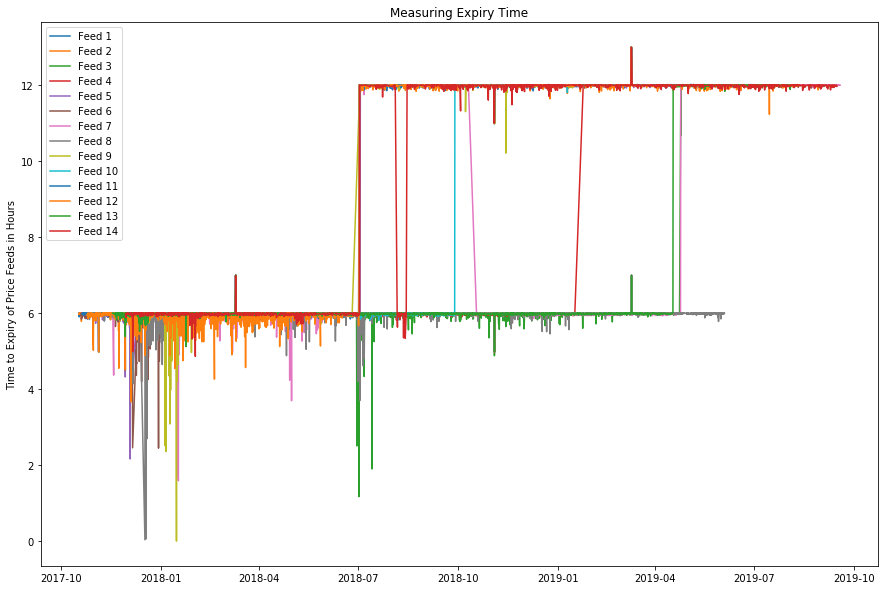

In [27]:
'''
We plot this again using dfs_raw later, which will be slightly different
because dfs_raw rounded off Age to the nearest integer
'''

plt.figure(figsize=(15,10)) 
for i in range(14):
    plt.plot(files[i].timeStamp, files[i]['Expire_'+ str(i+1)], label = "Feed " + str(i+1))
plt.legend()
plt.ylabel("Time to Expiry of Price Feeds in Hours")
plt.title("Measuring Expiry Time")
plt.savefig("OLD_Measuring Price Feed Age")

### Creating dfs_raw: No Forward Fill

In [28]:
dfs_raw = files[0].merge(files[1], how = 'outer', sort = True)
for i in range(2,14):
    dfs_raw = dfs_raw.merge(files[i], how = 'outer', sort = True)
    
for i in range(1,15):
    dfs_raw['Expire_'+str(i)] = dfs_raw['Expire_'+str(i)].round(0)

dfs_raw['timeStamp'] = dfs_raw.timeStamp.apply(lambda x: x.replace(second = 0, minute = 0) + timedelta(hours = 1))
dfs_raw = dfs_raw.groupby('timeStamp').last()

In [29]:
myrange = dfs_raw.loc['2019-05-18 00:00:00':'2019-09-17 15:00:00'].index
dfs_raw = dfs_raw.drop(index = myrange)

In [188]:
round(1.5, 0)

2.0

### Creating dfs_ff: Forward Fill by Age

In [43]:
dfs_ff = dfs_raw.copy(deep = True)

In [44]:
def can_forward_fill_next(current_row, feeder, raw_data):
    current_price_value = raw_data.iloc[current_row]["Feeder_" + str(feeder)]
    next_price_value = raw_data.iloc[current_row + 1]["Feeder_" + str(feeder)]
    current_price_age = raw_data.iloc[current_row]["Expire_" + str(feeder)]
    if np.isnan(current_price_value) == False and np.isnan(next_price_value) == True:
        #Maker's condition where bool = True if now < zzz 
        if current_price_age > 0:
            return True
        else: 
            return False
    return False

In [45]:
for row in range(0,len(dfs_ff.index) - 1):
    for i in range(1,15):
        if can_forward_fill_next(row, i, dfs_ff):
            #forward fill next row value using current row value
            dfs_ff.iloc[row + 1]["Feeder_"+str(i)] = dfs_ff.iloc[row]["Feeder_"+str(i)] 
            #decrement expiry by one hour
            dfs_ff.iloc[row + 1]["Expire_"+str(i)] = dfs_ff.iloc[row]["Expire_"+str(i)] - 1

'''
Note there might be some edge cases when Age is between 1 and 0: since we rounded to the hour
so sometimes when in reality Medianizer may not include a price in its computation we would, 
as are rounded to the nearest hour. E.g.: dfs_ff.iloc[990:1020]
'''

'\nNote there might be some edge cases when Age is between 1 and 0: since we rounded to the hour\nso sometimes when in reality Medianizer may not include a price in its computation we would, \nas are rounded to the nearest hour. E.g.: dfs_ff.iloc[990:1020]\n'

## External Disagreement

In [46]:
def median_compare(s1,s2, label, ifLog):
    diff = s1 - s2
    print('mean = {:.2f}, std = {:.2f}, max =  {:.2f}'.format(abs(diff).mean(), abs(diff).std(), abs(diff).max()))
    print()
    print(diff.loc[diff == diff.min()])
    print(diff.loc[diff == diff.max()])
    hist = plt.hist(diff, bins = 30, color = "slategrey")
    if ifLog:
        plt.yscale('log')
    plt.title("Aggregation Differences - {}".format(label))
    plt.savefig("Aggregation Differences - {}".format(label))
    plt.grid()
    plt.show()
    
def get_top3(a, b):
    #a and b are 2 dfs
    diff = abs(a - b).sort_values(ascending = False)
    location = []
    values = []
    for i in range(3):
        pos = diff.index[diff == diff[i]][0]
        location.append(pos)
        values.append(diff[i])
    return location, values

In [47]:
#sanity check
print(sum(dfs_raw.index == dfs_ff.index))
print(len(dfs_raw.index))

11080
11080


#### CryptoCompare CCCAGG

In [48]:
#CryptoCompare - obtain the data from drive
path = '/Users/WGu/Desktop/Blockchain/Stable Coins/ETH:USD/histohour'
ccfile = json.load(open(path+'.json'))['Data']
ccdf = pd.DataFrame(ccfile)
for i in range(1,13):
    path1 = path + " (" + str(i) + ').json'
    ccfile1 = json.load(open(path1))['Data']
    ccdf1 = pd.DataFrame(ccfile1)
    ccdf = pd.concat([ccdf, ccdf1])
ccdf.time = ccdf.time.apply(datetime.fromtimestamp)
ccdf.sort_values(by = ['time'], ascending = True, inplace = True)

#remove duplicate entries by column 'time'
ccdf = ccdf.drop_duplicates(subset = 'time', keep = 'last')
ccdf = ccdf.set_index('time')

#CryptoCompare data missing one entry 2019-03-10 02:00:00 so repopulate such that data_range matchs dfs
ccdf = ccdf.reindex(dfs_raw.index, method = 'ffill')

In [49]:
def select_columns(df):
    df_compute = df.copy(deep = True)
    for i in range(1,15):
        df_compute = df_compute.drop(columns= 'Expire_' + str(i))
    return df_compute

#### Creating Median for dfs_raw, dfs_ff

In [50]:
dfs_raw_compute = select_columns(dfs_raw)
dfs_raw_compute['median'] = dfs_raw_compute.median(axis = 1, skipna = True)

dfs_ff_compute = select_columns(dfs_ff)
dfs_ff_compute['median'] = dfs_ff_compute.median(axis = 1, skipna = True)

#### Creating Winsorized Mean for dfs_ff

In [51]:
dfs_ff_winsor_compute = select_columns(dfs_ff)
winsor = sts.mstats.winsorize(dfs_ff_winsor_compute, limits=[0.05, 0.05], axis = 1)
dfs_ff_winsor = pd.DataFrame(np.ma.filled(winsor), index = dfs_ff_winsor_compute.index)
dfs_ff_winsor['winsor_mean'] = dfs_ff_winsor.mean(axis = 1, skipna = True).round(3)

### Compare Robust Statistics

In [52]:
s1 = dfs_raw_compute['median']
s2 = dfs_ff_compute['median'] #Maker
s3 = dfs_ff_winsor['winsor_mean']
s_cc = (ccdf['open'] + ccdf['close']) / 2

mean = 3.33, std = 4.79, max =  153.73

timeStamp
2018-02-02 05:00:00   -153.73
dtype: float64
timeStamp
2018-01-10 19:00:00    67.89
dtype: float64


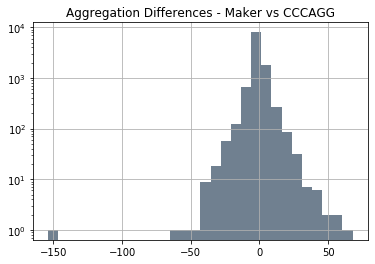

mean = 1.43, std = 2.15, max =  38.67

timeStamp
2018-01-18 14:00:00   -16.355
Name: median, dtype: float64
timeStamp
2018-01-17 14:00:00    38.675
Name: median, dtype: float64


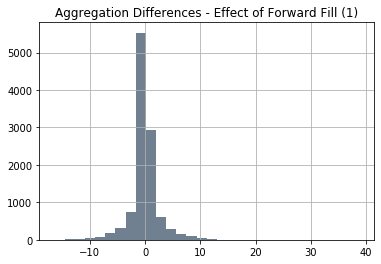

mean = 0.69, std = 1.18, max =  20.85

timeStamp
2018-01-16 14:00:00   -20.313
dtype: float64
timeStamp
2017-12-22 08:00:00    20.847
dtype: float64


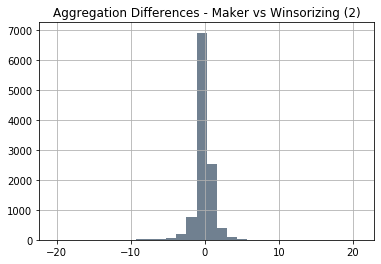

mean = 1.67, std = 2.13, max =  32.92

timeStamp
2018-01-16 14:00:00   -24.998
dtype: float64
timeStamp
2018-01-17 14:00:00    32.918
dtype: float64


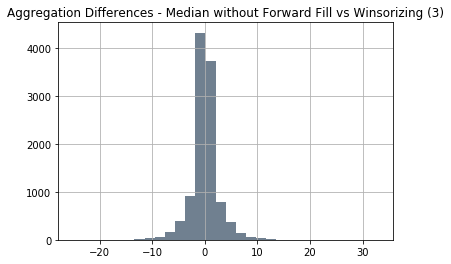

In [53]:
median_compare(s2, s_cc, "Maker vs CCCAGG", True)
median_compare(s1, s2, 'Effect of Forward Fill (1)', False)
median_compare(s2, s3, "Maker vs Winsorizing (2)", False)
median_compare(s1, s3, "Median without Forward Fill vs Winsorizing (3)", False)

In [54]:
diff = s1 - s2
np.count_nonzero(diff) / len(diff)

0.9043321299638989

### Get Top 3 Events

In [62]:
'''
Henceforth, use s2 vs s_cc: since s2 is replicating Maker with forward fill
'''
events, values = get_top3(s2, s_cc)
print(events)

[Timestamp('2018-02-02 05:00:00'), Timestamp('2018-01-10 19:00:00'), Timestamp('2018-01-16 18:00:00')]


In [63]:
def get_results(event):
    print("CCCAGG vs median: ")
    print((ccdf.loc[event].open + ccdf.loc[event].close)/2, dfs_ff_compute.loc[event]['median'])
    print()
    print("Feeder prices: ")
    print(dfs_ff_compute.loc[event])

#### Event 1

In [64]:
print(events[0], "Aggregate Difference: ", values[0])

2018-02-02 05:00:00 Aggregate Difference:  153.73000000000002


In [65]:
get_results(events[0])

CCCAGG vs median: 
908.75 755.02

Feeder prices: 
Feeder_1     748.185
Feeder_2     748.185
Feeder_3     824.020
Feeder_4     742.000
Feeder_5     825.305
Feeder_6     794.780
Feeder_7     754.895
Feeder_8     755.145
Feeder_9     755.980
Feeder_10    754.880
Feeder_11    739.925
Feeder_12    780.000
Feeder_13    749.360
Feeder_14    876.300
median       755.020
Name: 2018-02-02 05:00:00, dtype: float64


In [66]:
(908.75-755.02) / 908.75

0.16916643741403029

In [67]:
# Gemini 2018-02-02 05:00:00	ETHUSD	948.26	948.26	922.98	922.99
# Coinbase 2018-02-02 05-AM	ETHUSD	943.61	946.05	915.55	915.55
print('Gemini', (948.26 + 922.98)/2)
print('Coinbase', (946.05 + 915.55)/2)

Gemini 935.62
Coinbase 930.8


In [68]:
dfs_ff.loc[events[0]]

Feeder_1     748.185
Expire_1       6.000
Feeder_2     748.185
Expire_2       6.000
Feeder_3     824.020
Expire_3       6.000
Feeder_4     742.000
Expire_4       6.000
Feeder_5     825.305
Expire_5       6.000
Feeder_6     794.780
Expire_6       6.000
Feeder_7     754.895
Expire_7       6.000
Feeder_8     755.145
Expire_8       6.000
Feeder_9     755.980
Expire_9       6.000
Feeder_10    754.880
Expire_10      6.000
Feeder_11    739.925
Expire_11      6.000
Feeder_12    780.000
Expire_12      5.000
Feeder_13    749.360
Expire_13      6.000
Feeder_14    876.300
Expire_14      3.000
Name: 2018-02-02 05:00:00, dtype: float64

#### Event 2

In [69]:
print(events[1], "Aggregate Difference: ", values[1])

2018-01-10 19:00:00 Aggregate Difference:  67.8900000000001


In [70]:
get_results(events[1])

CCCAGG vs median: 
1240.31 1308.2

Feeder prices: 
Feeder_1     1314.000
Feeder_2     1315.000
Feeder_3     1309.215
Feeder_4     1288.000
Feeder_5     1308.400
Feeder_6     1306.600
Feeder_7     1307.055
Feeder_8     1299.000
Feeder_9     1306.600
Feeder_10    1308.900
Feeder_11    1311.990
Feeder_12    1295.010
Feeder_13    1308.000
Feeder_14    1311.980
median       1308.200
Name: 2018-01-10 19:00:00, dtype: float64


In [71]:
1240.31 - 1308.2

-67.8900000000001

In [72]:
# Gemini 2018-01-10 19:00:00	ETHUSD	1287.0	1310.96	1266.6	1302.04
# Coinbase 2018-01-10 07-PM	ETHUSD	1288	1308	1271.01	1304.37
print('Gemini', (1310.96 + 1266.6)/2)
print('Coinbase', (1308 + 1271.01)/2)

Gemini 1288.78
Coinbase 1289.505


In [73]:
dfs_ff.loc[events[1]]

Feeder_1     1314.000
Expire_1        4.000
Feeder_2     1315.000
Expire_2        4.000
Feeder_3     1309.215
Expire_3        4.000
Feeder_4     1288.000
Expire_4        5.000
Feeder_5     1308.400
Expire_5        4.000
Feeder_6     1306.600
Expire_6        6.000
Feeder_7     1307.055
Expire_7        4.000
Feeder_8     1299.000
Expire_8        5.000
Feeder_9     1306.600
Expire_9        6.000
Feeder_10    1308.900
Expire_10       4.000
Feeder_11    1311.990
Expire_11       4.000
Feeder_12    1295.010
Expire_12       5.000
Feeder_13    1308.000
Expire_13       4.000
Feeder_14    1311.980
Expire_14       4.000
Name: 2018-01-10 19:00:00, dtype: float64

#### Event 3

In [74]:
print(events[2], "Aggregate Difference: ", values[2])

2018-01-16 18:00:00 Aggregate Difference:  59.8449999999998


In [75]:
get_results(events[2])

CCCAGG vs median: 
1004.0 1063.8449999999998

Feeder prices: 
Feeder_1     1066.640
Feeder_2     1066.640
Feeder_3     1063.690
Feeder_4     1066.640
Feeder_5     1058.900
Feeder_6     1052.000
Feeder_7      911.130
Feeder_8     1074.290
Feeder_9     1055.000
Feeder_10    1066.610
Feeder_11    1064.000
Feeder_12    1061.660
Feeder_13    1070.000
Feeder_14    1063.500
median       1063.845
Name: 2018-01-16 18:00:00, dtype: float64


In [76]:
# Gemini 2018-01-16 18:00:00	ETHUSD	1039.95	1071.7	1008.02	1055.0
# Coinbase 2018-01-16 06-PM	ETHUSD	1041	1072	1006	1058
print('Gemini', (1071.7 + 1008.02)/2)
print('Coinbase', (1072 + 1006)/2)

Gemini 1039.8600000000001
Coinbase 1039.0


In [77]:
dfs_ff.loc[events[2]]

Feeder_1     1066.64
Expire_1        6.00
Feeder_2     1066.64
Expire_2        6.00
Feeder_3     1063.69
Expire_3        6.00
Feeder_4     1066.64
Expire_4        6.00
Feeder_5     1058.90
Expire_5        6.00
Feeder_6     1052.00
Expire_6        6.00
Feeder_7      911.13
Expire_7        2.00
Feeder_8     1074.29
Expire_8        6.00
Feeder_9     1055.00
Expire_9        6.00
Feeder_10    1066.61
Expire_10       6.00
Feeder_11    1064.00
Expire_11       6.00
Feeder_12    1061.66
Expire_12       6.00
Feeder_13    1070.00
Expire_13       6.00
Feeder_14    1063.50
Expire_14       6.00
Name: 2018-01-16 18:00:00, dtype: float64

## Internal Disagreement

### Boxplot

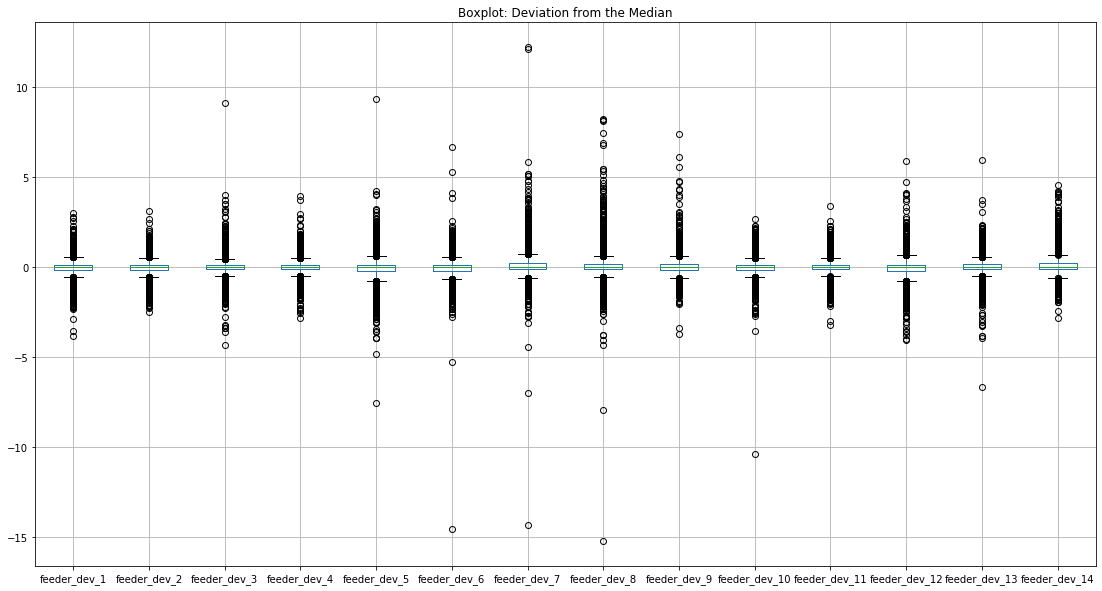

In [78]:
'''
Use dfs_raw, **without ** forward fill, for everything that follows
'''

dfs_dev = pd.DataFrame(index = dfs_raw_compute.index)
for i in range(1, 15):
    # *percentage* deviations from the median are calculated as %
    dfs_dev['feeder_dev_'+str(i)] = (dfs_raw_compute['Feeder_'+str(i)] - dfs_raw_compute['median'])/dfs_raw_compute["median"] * 100
    
plt.figure(figsize=(19,10))
dfs_dev_bp = dfs_dev.loc[:,"feeder_dev_1" :  "feeder_dev_14"]
dfs_dev_bp.boxplot()
plt.title("Boxplot: Deviation from the Median")
plt.savefig("Boxplot: Deviation from the Median")
plt.show()    

In [79]:
abs(dfs_dev.feeder_dev_7).max()

14.35500472343245

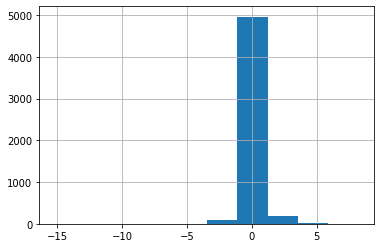

In [80]:
dfs_dev.feeder_dev_8.hist()

In [81]:
col = list(dfs_dev)
mean = [round(np.mean(dfs_dev[c]),3) for c in col]
sd = [round(np.std(dfs_dev[c]),3) for c in col]
stats = pd.DataFrame({'Feeders': col, 
                     'mean': mean,
                     'standard deviation': sd})
stats = stats.set_index('Feeders')
stats

,mean,standard deviation
Feeders,,
feeder_dev_1,-0.017,0.466
feeder_dev_2,-0.014,0.449
feeder_dev_3,-0.002,0.544
feeder_dev_4,0.013,0.471
feeder_dev_5,-0.070,0.674
feeder_dev_6,-0.051,0.538
feeder_dev_7,0.095,0.746
feeder_dev_8,0.086,0.714
feeder_dev_9,0.024,0.539


In [82]:
stats.loc['feeder_dev_8']

mean                  0.086
standard deviation    0.714
Name: feeder_dev_8, dtype: float64

In [83]:
#standard deviations: if 2 s.d., reject 3.8% data by Feeder 8
i = 2
pos = np.sum(dfs_dev.feeder_dev_8 > 0.086 + i*0.714)
neg = np.sum(dfs_dev.feeder_dev_8 < 0.086 - i*0.714)
nan = np.sum(dfs_dev.feeder_dev_8.isna())
tot = len(dfs_dev.feeder_dev_8)
print((pos + neg) / (tot - nan))
print(pos, neg, pos+neg, tot - nan)

0.03775374691709353
133 66 199 5271


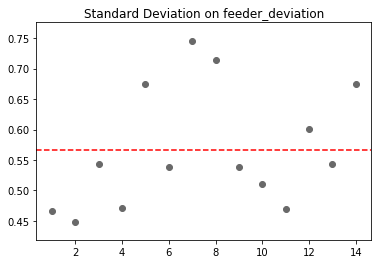

In [84]:
#scatter plot showing each oracle's s.d on its perc_dev from the mean price
plt.scatter(x = np.arange(1,15),y = stats["standard deviation"], color = 'dimgray')
plt.axhline(y= np.mean(stats["standard deviation"]), color='r', linestyle='dashed')
plt.title("Standard Deviation on feeder_deviation")
plt.savefig("Standard Deviation on feeder_deviation")

In [49]:
timeslice = abs(dfs_dev[['feeder_dev_8']]).idxmax()[0]
print('Event: {}'.format(timeslice))
print(abs(dfs_dev[['feeder_dev_8']]).max())

Event: 2017-12-22 08:00:00
feeder_dev_8    15.22777
dtype: float64


In [50]:
Feeder_8_dev = pd.Series(dfs_dev['feeder_dev_8'])
top_dev_event = abs(Feeder_8_dev).sort_values(ascending = False)[:5]
for each in top_dev_event.index:
    print(each, dfs_dev.loc[each]['feeder_dev_8'].round(2))

2017-12-22 08:00:00 -15.23
2017-12-12 19:00:00 8.27
2017-12-19 17:00:00 8.17
2018-01-16 06:00:00 8.13
2018-01-16 04:00:00 -7.93


## Low Activity

#### Across all feeders - entire dataset

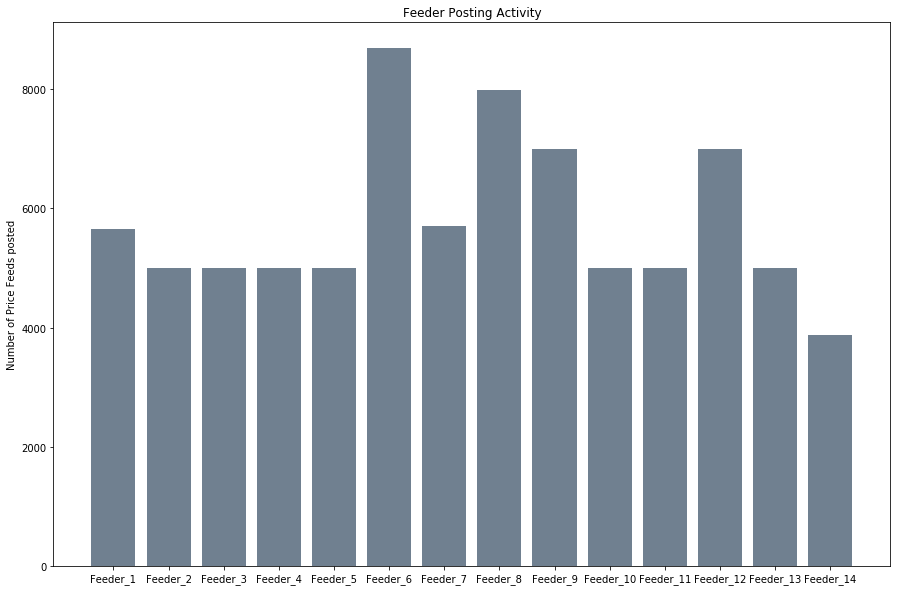

In [51]:
#Using rounded hourly snapshot to aggregate

# feeds = list(dfs_raw_compute)
# activity = []
# for feed in feeds:
#     active = sum(~np.isnan(dfs_raw_compute[feed]))
#     activity.append(active)

# plt.figure(figsize=(15,10))    
# plt.bar(feeds[:14], activity[:14], color = "slategray")
# plt.ylabel("Number of Price Feeds posted")
# plt.title("Feeder Posting Activity")
# plt.savefig("Feeder Posting Activity")
# plt.show()

activity = files[0].merge(files[1], how = 'outer', sort = True)
for i in range(2,14):
    activity = activity.merge(files[i], how = 'outer', sort = True)
for i in range(1, 15):    
    activity = activity.drop(columns = ['Expire_'+str(i)])
activity = activity.set_index('timeStamp')
feeds = list(activity)
activity_list = []
for feed in feeds:
    active = sum(~np.isnan(activity[feed]))
    activity_list.append(active)

plt.figure(figsize=(15,10))    
plt.bar(feeds, activity_list, color = "slategray")
plt.ylabel("Number of Price Feeds posted")
plt.title("Feeder Posting Activity")
plt.savefig("Feeder Posting Activity")
plt.show()

#### Pick some feeders - across every hour in a day

#### Price Age

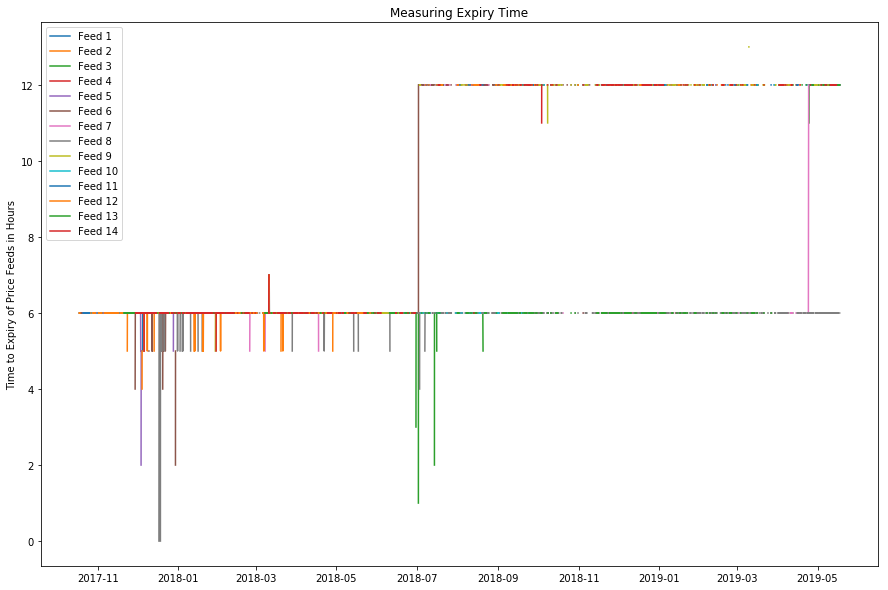

In [52]:
plt.figure(figsize=(15,10)) 
for i in range(14):
    plt.plot(dfs_raw.index, dfs_raw['Expire_'+ str(i+1)], label = "Feed " + str(i+1))
plt.legend()

plt.ylabel("Time to Expiry of Price Feeds in Hours")
plt.title("Measuring Expiry Time")
plt.savefig("Measuring Price Expiry Time - ALL")

In [53]:
def measure_staleness(choice, title):
    dfs_ff['Expire_'+ str(choice)].hist(bins = np.arange(15), color = 'lightslategrey')
    plt.xlabel("Price Feeds Expiry in Hours")
    plt.ylabel("Frequency")
    plt.title("Measuring Price Staleness for " + title)
    plt.savefig("Measuring Price Staleness for " + title)

In [ ]:
measure_staleness(9, "Feeder 9")

In [ ]:
measure_staleness(8, "Feeder 8")

In [ ]:
measure_staleness(13, "Feeder 13")

#### Measuring Time Gap


In [54]:
hours_list = []
for i in range(len(files)):
    files[i]['TimeGap_' + str(i+1)] = (files[i]['timeStamp'] - files[i]['timeStamp'].shift()).fillna(pd.to_timedelta("00:00:00"))
    hours = files[i]["TimeGap_" + str(i+1)].dt.components['hours']
    hours_list.append(hours)
    print(i+1, len(hours))

1 5650
2 4996
3 4995
4 4995
5 4995
6 8691
7 5713
8 7987
9 6992
10 4996
11 4996
12 6993
13 4996
14 3885


In [55]:
def time_gap_graph(feeder):
    hours_list[feeder-1].hist(bins = np.arange(15), color = 'lightslategrey')
    plt.xlabel("Time Gap between Posting (hours)")
    plt.ylabel("Frequency")
    plt.title("Time Gap between Posting for Feeder " + str(feeder))
    plt.savefig("Time Gap for Feeder " + str(feeder))

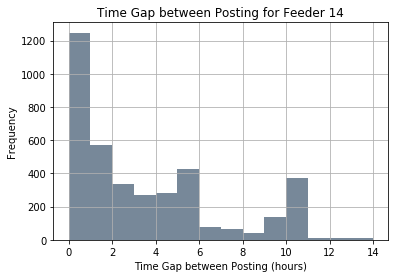

In [69]:
time_gap_graph(14)

## Hypothesis Testing

### Hypothesis testing of the Largest Deviation: 2017 Dec 22, at 8am by Oracle 8

In [70]:
event = "2017-12-22 08:00:00"
time_slice1 = dfs_raw_compute.loc[event]
print("At {}, {} feeders did not report prices".format(time_slice1.name, time_slice1.isna().sum()))
time_slice1

At 2017-12-22 08:00:00, 3 feeders did not report prices


Feeder_1     626.947
Feeder_2     641.777
Feeder_3     635.510
Feeder_4     619.891
Feeder_5         NaN
Feeder_6     542.988
Feeder_7         NaN
Feeder_8     538.736
Feeder_9         NaN
Feeder_10    646.245
Feeder_11    648.504
Feeder_12    631.490
Feeder_13    650.443
Feeder_14    642.943
median       635.510
Name: 2017-12-22 08:00:00, dtype: float64

In [71]:
time_slice1 = time_slice1.rename('With Feeder 8')

#### Method 1

Excluding Feeder 8, ML_mean: 628.67 ; ML_std: 30.05
Median reported price:  635.51
Feeder 8 reported 538.74
Feeder 8 has a -15.23% deviation from the median, and is 2.99 s.d. away from the mean

P-value that Feeder 8 is reporting truthfully: 0.00276



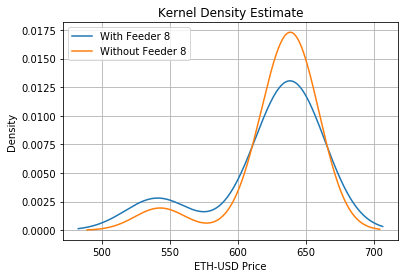

In [72]:
#Methodology 1 (to be discarded) - ML per time slice, but not enough data points

Feeder_8 = time_slice1["Feeder_8"]
Feeder_8_dev = (Feeder_8 - time_slice1["median"]) / time_slice1["median"]
time_slice1_without8 = time_slice1.drop("Feeder_8")
time_slice1_without8 = time_slice1_without8.rename("Without Feeder 8")

#maximum likelihood
mu = np.mean(time_slice1_without8[:-1])
s = np.std(time_slice1_without8[:-1])
print("Excluding Feeder 8, ML_mean: {:.2f}".format(mu), "; ML_std: {:.2f}".format(s))
print("Median reported price: {: .2f}".format(time_slice1.loc["median"]))
print('Feeder 8 reported {:.2f}'.format(Feeder_8))
print("Feeder 8 has a {:.2f}% deviation from the median, and is {:.2f} s.d. away from the mean".format(Feeder_8_dev * 100, abs((Feeder_8 - mu)/ s)))
print()

#Cross-sectional examination: given the time slice of a specific hour, carry hypothesis testing assuming CLT
p1 = 2 * (1 - sts.norm.cdf(np.abs(Feeder_8 - mu), loc = 0, scale = s))
print("P-value that Feeder 8 is reporting truthfully: {:.5f}".format(p1))
print()

#Generate Kernel Density Estimate plot using Gaussian kernels.
graph1 = time_slice1.plot.kde()
graph2 = time_slice1_without8.plot.kde()
graph1.set_label('a')
graph2.set_label('b')
plt.xlabel('ETH-USD Price')
plt.title("Kernel Density Estimate")
plt.grid()
plt.legend()
plt.savefig("KDE")

#### Method 2


Feeder 8 perc_dev - mean: 0.086, s.d: 0.714, dev: -15.227769822662129
P-value that Feeder 8 is reporting truthfully:  0.0


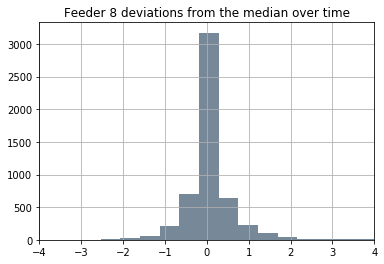

In [73]:
# Methodology 2 (preferred) - ML per Feeder using the entire time history
dfs_dev.feeder_dev_8.hist(bins = 50, color = 'lightslategrey')
plt.title("Feeder 8 deviations from the median over time")
plt.xlim(-4, 4)
plt.savefig("Histogram for Feeder 8 price deviation")
print()

#Time series examination: look at Feeder 8 historical deviations, assuming its deviations are normally distributed around mean 0
mu_8 = stats.loc['feeder_dev_8']['mean']
s_8 = stats.loc['feeder_dev_8']['standard deviation']
p2 = 2 * (1 - sts.norm.cdf(np.abs(Feeder_8_dev * 100 - mu_8), loc = 0, scale = s_8))
print('Feeder 8 perc_dev - mean: {}, s.d: {}, dev: {}'.format(mu_8, s_8, Feeder_8_dev * 100))
print("P-value that Feeder 8 is reporting truthfully: ", p2)